# Import the relevant libraries

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Import the dataset

In [7]:
DIR = "WasteImagesDataset/"
IMG_SIZE = (256, 256)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    validation_split=0.1,
    subset="training",
    seed=42,
    batch_size=16,
    image_size=IMG_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    validation_split=0.1,
    subset="validation",
    seed=42,
    batch_size=16,
    image_size=IMG_SIZE
)


Found 3848 files belonging to 4 classes.
Using 3464 files for training.
Found 3848 files belonging to 4 classes.
Using 384 files for validation.


### Optimise the training and testing performance

In [8]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['Cardboard', 'Glass', 'Metal', 'Plastic'] 4


### Performing Data Augmentation

In [9]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D

data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

preprocess_input = preprocess_input
global_average_layer = GlobalAveragePooling2D()


# MODELS

### Basic CNN

In [5]:
# model = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),

#     tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
    
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(numClasses, activation='softmax')
# ])

### Inception V3 Model

In [6]:
# Inception_V3_Model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
#                                              weights='imagenet',
#                                              include_top=False,
#                                              classes=numClasses)

# for layer in Inception_V3_Model.layers[:249]:
#     layer.trainable = False

# for layer in Inception_V3_Model.layers[249:]:
#     layer.trainable = True

# last_output = data_augmentation(Inception_V3_Model.output)
# maxpooled_output = tf.keras.layers.Flatten()(last_output)

# x = tf.keras.layers.Dense(1024, activation='relu')(maxpooled_output)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

# inception_model = tf.keras.Model(inputs=Inception_V3_Model.input, outputs=x)

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

# inception_model.compile(optimizer=optimizer,
#                         loss=loss,
#                         metrics=['accuracy'])

# history = inception_model.fit(train_dataset, epochs=10)

### Resnet152 Model 

In [ ]:
# Define your model architecture
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                            include_top=False, classes=numClasses)

for layer in baseModel.layers:
    layer.trainable = False

last_output = baseModel.layers[-1].output



x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

# Train the model
epochs = 10
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

# Save the trained model
model.save("simple_keras.keras")


Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.7635 - loss: 1.0418 - val_accuracy: 0.8880 - val_loss: 0.3146
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1003s 5s/step - accuracy: 0.9492 - loss: 0.1347 - val_accuracy: 0.9167 - val_loss: 0.3424
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1000s 5s/step - accuracy: 0.9866 - loss: 0.0442 - val_accuracy: 0.9010 - val_loss: 0.3713


In [22]:
# Load the saved model
model = tf.keras.models.load_model("simple_keras.keras")

/home/martim/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1250 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


### Retrain Model


In [29]:
import tensorflow as tf

# Assuming train_dataset and test_dataset are already defined

# Print the shape of the input data just before training
sample_input = next(iter(train_dataset))  # Get a sample input from the training dataset
img_array, label = sample_input  # Assuming the input data is a tuple (image, label)
print("Shape of input data in new dataset:", img_array.shape)

# Train the model
epochs = 10
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

# Save the retrained model
model.save("retrained_model.keras")


Shape of input data in new dataset: (256, 256, 3)
Epoch 1/10


ValueError: as_list() is not defined on an unknown TensorShape.

### Model Evaluation

In [8]:
# plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
# plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
# plt.legend()
# plt.show()

In [9]:
# plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
# plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
# plt.legend()
# plt.show()

In [10]:
# plt.xlim([0, 0.003])
# learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
# plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
# plt.title('Learning rate vs. loss', size=20)
# plt.xlabel('Learning rate', size=14)
# plt.ylabel('Loss', size=14)

### MobileNetV3

In [11]:
# baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', 
#                                                    include_top=False, classes=numClasses)
# for layers in baseModel.layers[:-6]:
#   layers.trainable=False

# last_output = baseModel.layers[-1].output
# x = tf.keras.layers.Dropout(0.45) (last_output)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.BatchNormalization() (x)
# x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, 
#                           kernel_regularizer=tf.keras.regularizers.l1(0.045), 
#                           activity_regularizer=tf.keras.regularizers.l1(0.045),  
#                           kernel_initializer='he_normal')(x)
# x = tf.keras.layers.Dropout(0.45) (x)
# x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

# model = tf.keras.Model(inputs=baseModel.input,outputs=x)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=['accuracy'])

# epochs = 50
# lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
# stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
# callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
# history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[9.9999977e+01 3.3284647e-12 2.7550732e-05 2.8253783e-10] 
 ['Cardboard', 'Glass', 'Metal', 'Plastic']
Prediction:  Cardboard 99.99997615814209%


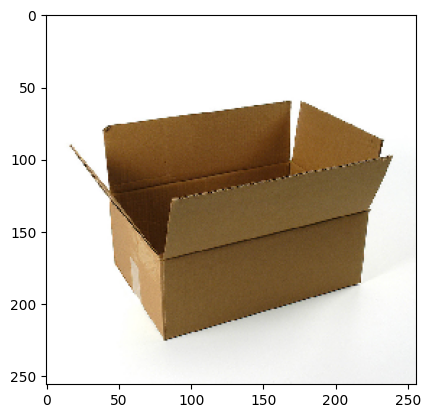

In [31]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
#model1 = load_model('my_model_keras.keras')

# Load the image from the local folder
image_path = 'cardboard.jpg'  # Replace 'local_image.jpg' with the actual path to your image file
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Perform prediction
predictions = model.predict(img_array)

plt.imshow(img)
# print(predictions)
# print("Prediction: " + str(classes[np.argmax(predictions)]))
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")



In [5]:
import requests

img_data = requests.get("https://media.istockphoto.com/id/1212377981/pt/foto/background-of-cardboard-boxes-inside-warehouse-logistic-center-warehouse-filled-with-cardboard.jpg?s=1024x1024&w=is&k=20&c=MeqRmYpV5C7NB6rapGu7C3Y4bnCnn8TkWsxQPfhgjw0=").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

NameError: name 'model' is not defined

# Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 1000x1000 with 0 Axes>

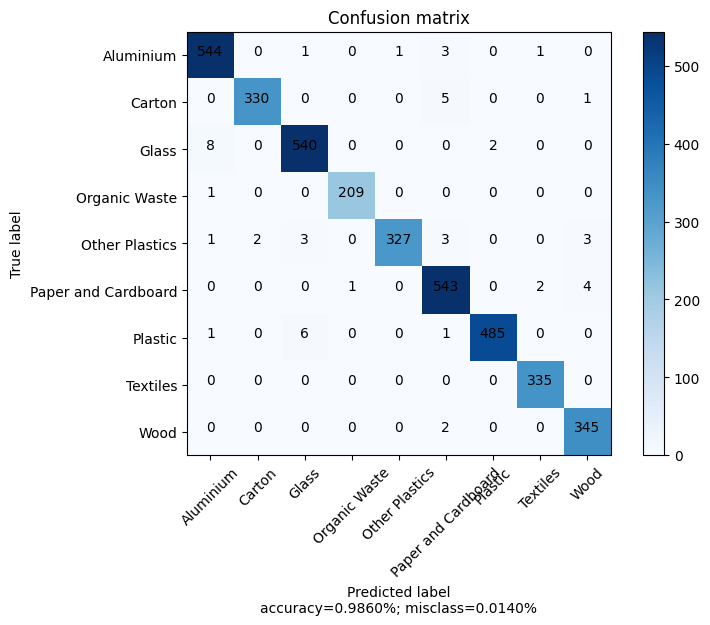

In [20]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

path = "WasteImagesDataset/"
for i in os.listdir(path):
    if not i.startswith('.'):  # Exclude system files
        folderPath = os.path.join(path, i)
        for j in os.listdir(folderPath)[:550]:
            fullPath = os.path.join(folderPath, j)
            try:
                img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = tf.expand_dims(img_array, 0) 

                preds = model.predict(img_array)
                true.append(classes.index(i))
                predictions.append(np.argmax(preds))
            except Exception as e:
                print("Error on image:", fullPath)
                print(e)


plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)